In [57]:
import os
import numpy as np
import tensorflow as tf

In [58]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [59]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# images must be saved sub folders of their class
def get_images_labels(target_dir, class_names, resize=None):
  # Setup target directory (we'll view images from here)
  labels = []
  imgs = []
  for idx, class_dir in enumerate(class_names):
    target_folder = target_dir+class_dir

    for img_file in os.listdir(target_folder):
      img = cv2.imread(target_folder + "/" + img_file)
      if resize: img = cv2.resize(img, resize)
      imgs.append(img)

      labels.append(idx)

  return (np.array(imgs), np.array(labels))

In [60]:
# view any image (at idx) from (imgs, labels) as output by "get_images_labels" function 
def view_image(imgs, labels, idx, class_names):
  img = imgs[idx]
  plt.imshow(img)
  plt.title(class_names[labels[idx]])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image



In [61]:
# view any image at random index from (imgs, labels) as output by "get_images_labels" function 
def view_random_image(imgs, labels, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]
  plt.imshow(img)

  shp = labels.shape
  label_idx = labels[idx]  
  if len(shp)==2: # if one hot encoded
    label_idx = tf.where(label_idx==1)[0][0]

  plt.title(class_names[label_idx])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image


In [62]:
def pred_and_plot(model, imgs, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))[0]

  # Get the predicted class
  if len(pred)==1: 
    pred_class = class_names[round(pred[0])]
  else:
    pred_class = class_names[int(tf.argmax(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [63]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import urllib.request
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
# from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
    
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

class_names = ['rock', 'paper', 'scissors']
parent_dir = r'/content/tmp/rps/'

In [64]:
(X, Y) = get_images_labels(parent_dir, class_names, resize=(150, 150))

In [65]:
Y = tf.one_hot(Y, 3)
Y

<tf.Tensor: shape=(2520, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [66]:
# will split images and labels into training and test (or validation) data
# images must be array length N x w x h x 3.
# labels must be Nx1 (sparse) or Nxdepth (not sparse)
# All images and labels must be in synchronous.
# There must be same number images for each label.
# All images must be ordered by label, where all images from first label come first, then
# all images from second label come second, and so on
# depth is number of classes
# split must be split size; data will be shuffled prior to split
def images_labels_split(imgs, lbls, depth, split=.2):
  train_imgs = []
  train_lbls = []
  
  test_imgs = []
  test_lbls = []

  N = len(imgs)
  
  if N!=len(lbls): raise Exception

  # size of images for each label
  n = int(N/depth)

  for k in range(depth):
    
    inds = np.linspace(0, n-1, n)
    np.random.shuffle(inds)

    ind_split = n - int(n*split)
    train_inds = inds[:ind_split]
    test_inds = inds[ind_split:]
    
    for train_ind in train_inds:
      train_ind = int(train_ind+k*n)
      train_imgs.append(imgs[train_ind])
      train_lbls.append(lbls[train_ind])


    for test_ind in test_inds:
      test_ind = int(test_ind+k*n)
      test_imgs.append(imgs[test_ind])
      test_lbls.append(lbls[test_ind])

  return (np.array(train_imgs), np.array(train_lbls), np.array(test_imgs), np.array(test_lbls))




In [67]:
X_train, Y_train, X_test, Y_test = images_labels_split(X, Y, depth=3, split=.2)

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)



In [69]:
train_data = datagen.flow(X_train, Y_train, batch_size=32, seed=42)

In [70]:
test_data = datagen.flow(X_test, Y_test, batch_size=32, seed=42)

Image shape: (150, 150, 3)


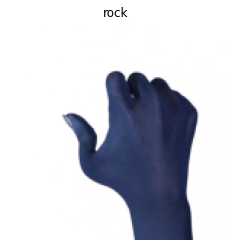

In [71]:
view_random_image(X, Y, class_names)

In [72]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)


train_data_augmented = train_datagen_augmented.flow(X_train, Y_train, batch_size=32, seed=42)

In [75]:
# Try a simplified model (removed two layers)
model = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

# Compile the cloned model (same setup as used for model_10)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data_augmented, # use augmented data
                          epochs=20,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/20
63/63 [==============================] - 12s 177ms/step - loss: 1.0804 - accuracy: 0.4053 - val_loss: 0.9682 - val_accuracy: 0.4802
Epoch 2/20
63/63 [==============================] - 11s 175ms/step - loss: 0.9088 - accuracy: 0.5923 - val_loss: 0.7495 - val_accuracy: 0.6567
Epoch 3/20
63/63 [==============================] - 11s 173ms/step - loss: 0.7590 - accuracy: 0.6860 - val_loss: 0.5162 - val_accuracy: 0.8472
Epoch 4/20
63/63 [==============================] - 11s 172ms/step - loss: 0.6291 - accuracy: 0.7569 - val_loss: 0.4596 - val_accuracy: 0.8829
Epoch 5/20
63/63 [==============================] - 11s 173ms/step - loss: 0.5716 - accuracy: 0.7763 - val_loss: 0.3606 - val_accuracy: 0.9405
Epoch 6/20
63/63 [==============================] - 11s 171ms/step - loss: 0.5423 - accuracy: 0.7882 - val_loss: 0.3274 - val_accuracy: 0.9008
Epoch 7/20
63/63 [==============================] - 11s 173ms/step - loss: 0.5041 - accuracy: 0.8070 - val_loss: 0.2904 - val_accuracy: 0.9365